## IDEA

<img src="./img/guided_sampling_score_function.jpg" alt="image" width="50%" height="auto">

**Langevin Dynamics는 다음과 같이 적용된다.**

$x_{t-1}=x_t+{\beta_t \over 2}score(x,c,\lambda)+\sqrt{\beta_t}\epsilon_t$

여기서 $\epsilon_t=\mathcal{N}(\epsilon_t|\mathbf{0}, \mathbf{I})$

In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from Unet import *
from DiffusionModel import *
from GuidedUnet import *

In [2]:
# define hyperparameters

image_size = 32
channel = 1

batchsize = 128

timestep = 300

lr = 1e-3
epochs = 1

delta = 0.5

dimmults = (1,2,4,8)

condition_shift= timestep + 100

device = "cuda:0" if torch.cuda.is_available() else "cpu"

#device = "cpu"
print(device)

cuda:0


In [3]:
# load models
loaded_linear_net = GuidedUnet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)

loaded_linear_net, linear_betas, linear_sqrt_one_minus_alphas = load_net_betas(loaded_linear_net, device, "linear_guided", "guided")


In [4]:
# make initial noise to check difference
init_noise = torch.randn((1,1,32,32))

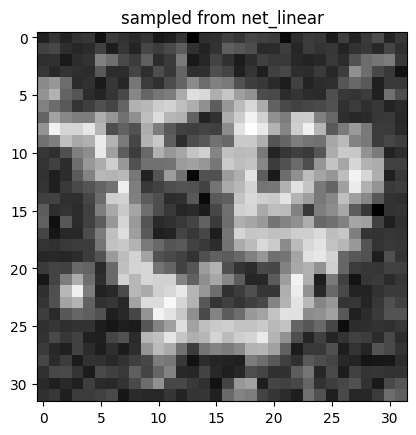

In [5]:
# sample from loaded model

condition = 5
delta = 1

res:torch.Tensor = sampling_guided(timestep, 
                                   condition, 
                                   delta, 
                                   linear_betas, 
                                   linear_sqrt_one_minus_alphas, 
                                   loaded_linear_net, 
                                   device,
                                   None,
                                   condition_shift)

plt.figure()
plt.title("sampled from net_linear")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')

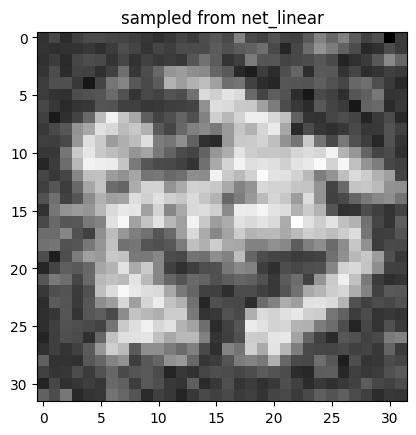

In [6]:
# sample from loaded model

condition = 5
delta = 0

res:torch.Tensor = sampling_guided(timestep, 
                                   condition, 
                                   delta, 
                                   linear_betas, 
                                   linear_sqrt_one_minus_alphas, 
                                   loaded_linear_net, 
                                   device,
                                   None,
                                   condition_shift)

plt.figure()
plt.title("sampled from net_linear")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')

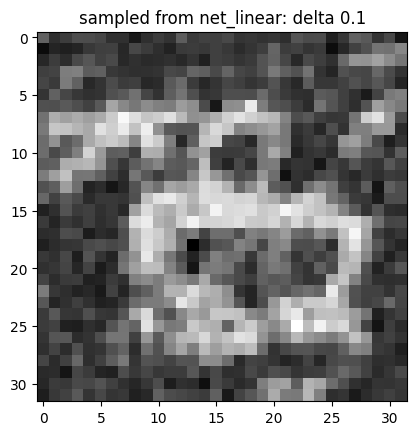

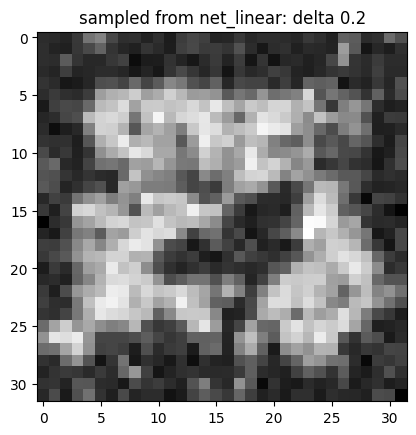

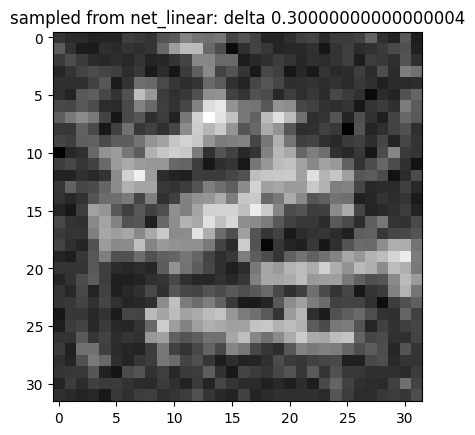

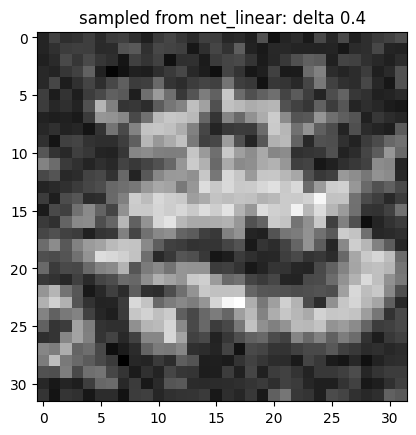

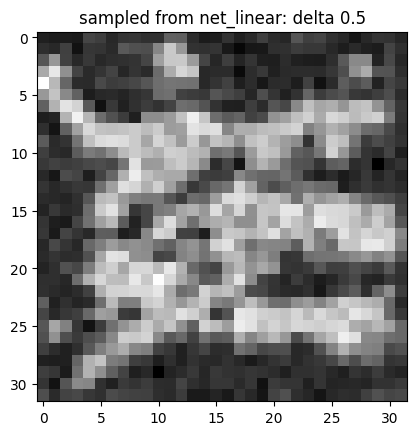

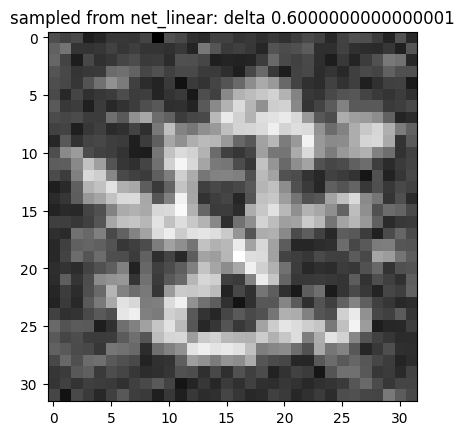

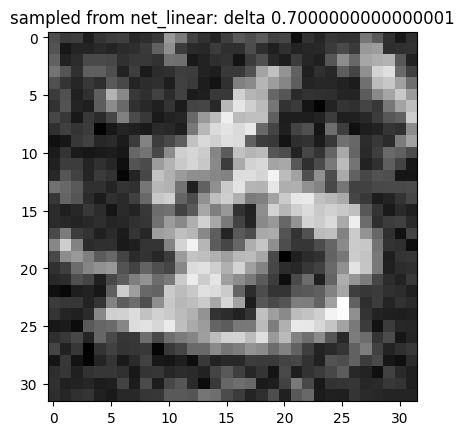

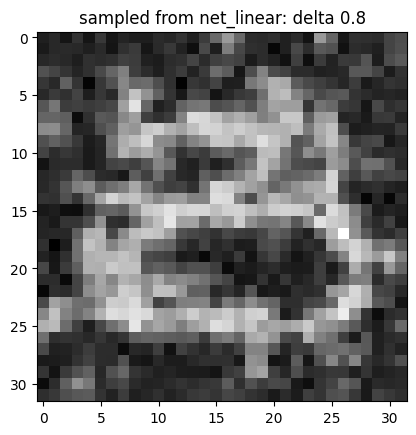

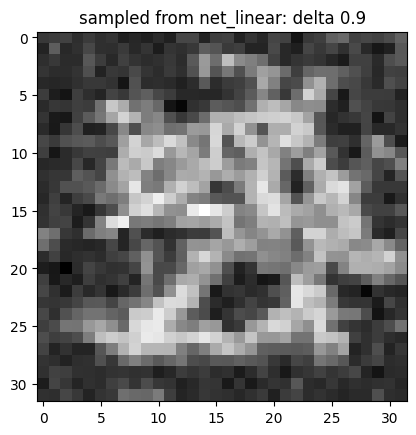

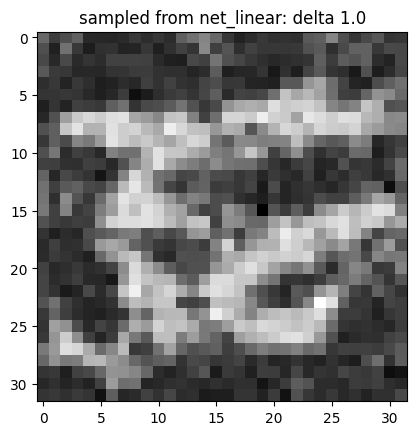

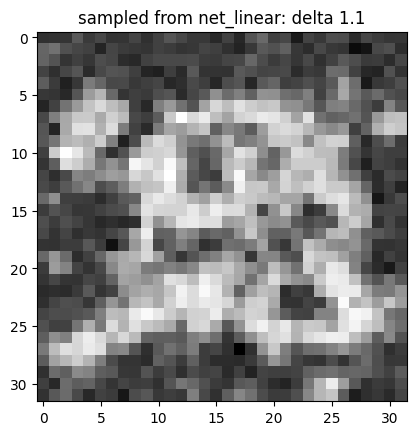

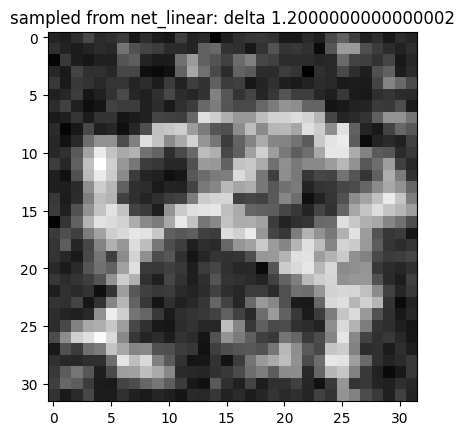

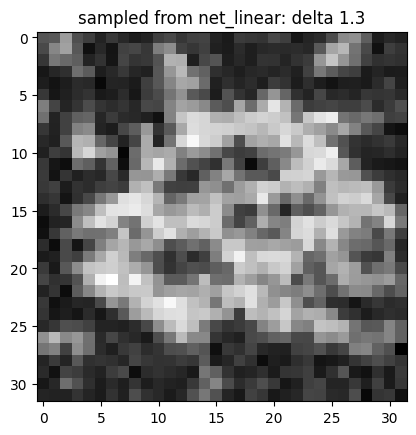

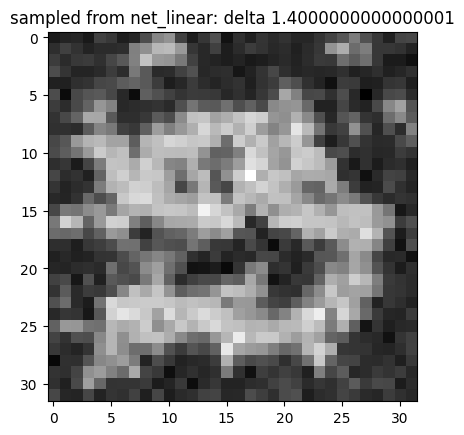

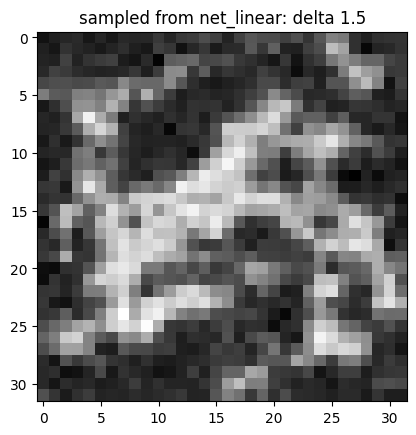

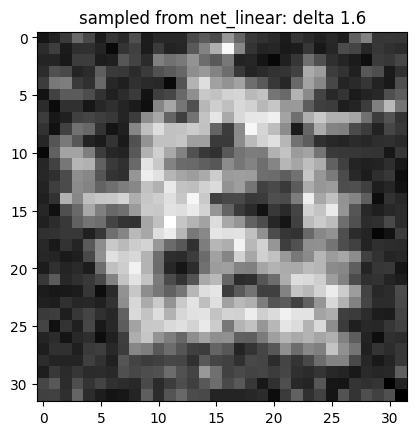

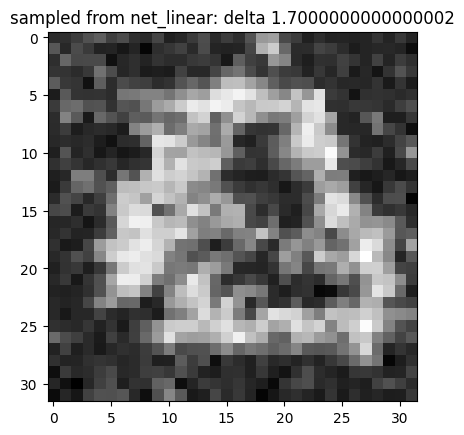

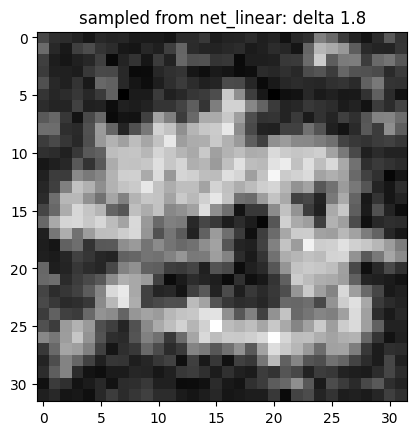

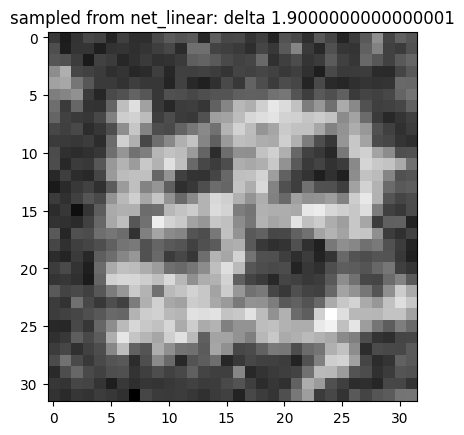

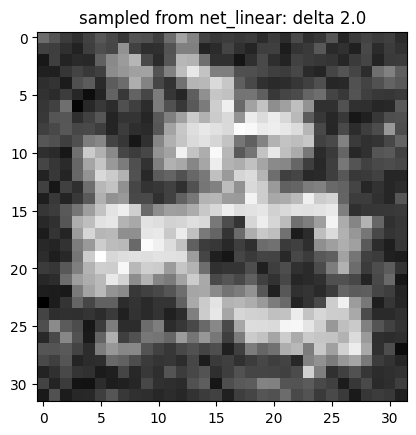

In [7]:
# check the difference between deltas

condition = 5
deltas = [0.1*i for i in range(1, 21)]

for delta in deltas:
    res:torch.Tensor = sampling_guided(timestep, 
                                    condition, 
                                    delta, 
                                    linear_betas, 
                                    linear_sqrt_one_minus_alphas, 
                                    loaded_linear_net, 
                                    device, 
                                    init_noise,
                                    condition_shift)

    plt.figure()
    plt.title(f"sampled from net_linear: delta {delta}")
    plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')